<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/Week3/PreTraining_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this experiment, we will train the **GPT-2 model** using the [BookCorpus](https://huggingface.co/datasets/bookcorpus/bookcorpus) dataset.

The relevant material for Week 3, like the trained model checkpoints can be found at : [Week 3 Pretraining GPT](https://drive.google.com/drive/folders/1DQwmmq9hLtIwfXVMKlYtNu_k9ZS7Nekx)

Let's get started.

In [1]:
!pip install datasets wandb > /dev/null

<h1 style="color:Tomato;"> Import the necessary Packages </h1>

In [2]:
# used in the previous experiments
from datasets import load_dataset,load_from_disk
from transformers import AutoTokenizer

# for training
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

#for experiment tracking
import wandb

#common packages
import pandas as pd
from pprint import pprint
import json
import numpy as np
from matplotlib import pyplot as plt

<h1 style="color:Tomato;"> Dataset </h1>

In [4]:
ds_full = load_dataset('bookcorpus',split='all')
pprint(ds_full)

Dataset({
    features: ['text'],
    num_rows: 74004228
})


The dataset contains 74 million sentences.


The dataset contains about 1 billion words (**Exercise:** write code to get the exact number.)

In [8]:
sum([len(sample.split()) for sample in ds_full['text']])

984845743

In [9]:
984845743/10**9

0.984845743

So yes, the dataset contains roughly about a billion words.

There are 71,598 samples that contain just a single word.

The **context length** of the **gpt-2** model is **1024**

There are 50 samples in the dataset that are larger than the **context length** of the model (with the largest sample containing 65,852 elements!).

Let us randomly select one million samples from the 74 million to better understand the distribution of the number of words in the sample sentences, excluding the 50 largest samples (outliers).

In [10]:
# download the bookcorpus dataset stats file : bc_stats.json
!gdown 1IWHxxMoNxaJq9IP5A46tKLuv-LTRiDDc

Downloading...
From (original): https://drive.google.com/uc?id=1IWHxxMoNxaJq9IP5A46tKLuv-LTRiDDc
From (redirected): https://drive.google.com/uc?id=1IWHxxMoNxaJq9IP5A46tKLuv-LTRiDDc&confirm=t&uuid=ae870423-9f89-4c37-8da9-5970c97d240b
To: /content/bc_stats.json
100% 266M/266M [00:03<00:00, 81.0MB/s]


In [11]:
with open('bc_stats.json','r') as f:
    bc_stats = json.load(f)

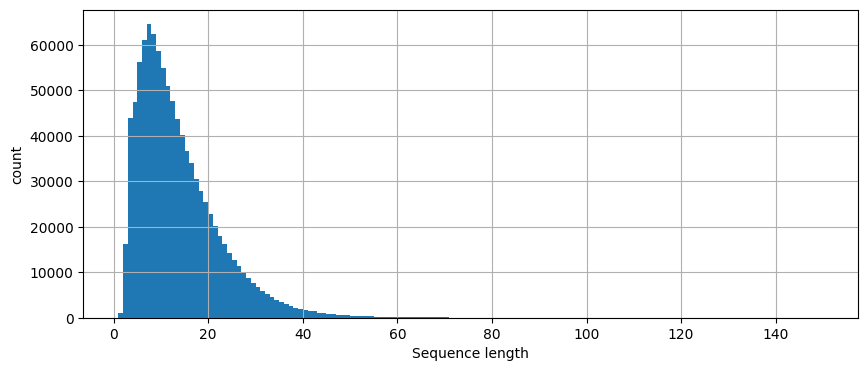

In [12]:
import random
sorted_len = bc_stats['len_samples_sorted']
bins = np.unique(sorted_len)
plt.figure(figsize=(10,4))
plt.hist(random.sample(sorted_len[0:-50],k=10**6),bins=bins[0:150])
plt.xlabel('Sequence length')
plt.ylabel('count')
plt.grid()
plt.show()

From the above plot, we can see that the length of a majority of the samples is far less than 60 and the <ins>average length of the sample sentences is about 13.</ins>

<h1 style="color:Tomato;"> Tokenization </h1>

The next step is to tokenize the samples using the `PreTrainedTokenizer`

We can use the `hopper` tokenizer that we have trained in the previous week


**Note** : **Don't run the below cells** (between the horizontal lines) where we're loading the hopper tokenizer from the last week, I don't have those files.



---


In [ ]:
hopper_tokenizer = AutoTokenizer.from_pretrained('../Week-2/hopper')
print(hopper_tokenizer)

PreTrainedTokenizerFast(name_or_path='../Week-2/hopper', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


Let us pass a batch of samples to the tokenizer with padding enabled:

In [ ]:
bs = 4 # batch_size
model_inputs = hopper_tokenizer(ds_full[0:bs]['text'],padding=True)
pprint(model_inputs['input_ids'],compact=True)

[[2462, 19, 149, 277, 162, 6456, 422, 131, 1559, 536, 19, 2301, 201, 177, 9774,
  21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [212, 297, 289, 456, 208, 46, 20830, 1420, 214, 4099, 1171, 139, 11126, 21, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [178, 206, 337, 7656, 14, 64, 1147, 303, 174, 503, 214, 2363, 2310, 21, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [149, 14, 49, 946, 131, 3760, 880, 375, 3446, 19, 3766, 149, 166, 46, 545,
  1185, 200, 131, 61, 93, 17794, 19, 212, 201, 2596, 9302, 19, 1050, 201, 163,
  3186, 19, 5696, 166, 2270, 5194, 138, 717, 178, 278, 2596, 21]]




---


We can see that the shorter samples have been padded (0 padding at the right) to keep the size consistent.


But what happens if a batch contains a sample of length 1 (and the size of other samples is 50)?

We will need to append 49 zeros to that shortest sample! It is a waste of compute (while pretraining)!

Moreover, if you observe carefully, the samples in the dataset **maintain continuity** with each other. The sentences are just continuing from where the previous one left off.

So instead of padding, why not concatenate multiple sentences together to create a new sample sentence which is of 1024 length? We can do this with all the sentences in the dataset, i.e., concatenate as many sentences as needed to make sure each new sample is 1024 length. And if a sample is larger than 1024 length, just take 1024 elements from it.

So finally, all the samples will be of length 1024.

In [ ]:
pprint({id:example for id,example in enumerate(ds_full[100:110]['text'])})

{0: 'he loved sitting between her brothers on the couch and watching tv .',
 1: 'while it was good that he had so many male role models , she only hoped '
    "he had n't inherited too much of his father 's personality .",
 2: 'after megan watched them disappear in the crowd of family and friends '
    'waiting in the church alcove , she bypassed everyone by turning right and '
    'heading down the hallway .',
 3: 'at the last door on the right , she knocked .',
 4: "`` it 's me , megan . ''",
 5: "emma 's best friend , casey , answered the door .",
 6: "`` well , if it is n't the fairy godmother , '' she mused with a grin .",
 7: 'after megan stepped inside , casey threw her arms around her .',
 8: "megan had only met her a few times , but it was hard not liking emma 's "
    'vivacious and outgoing friend .',
 9: "casey 's long brown hair was pulled back in a lose knot , and she wore a "
    'demure black slip dress and heels .'}


Therefore, to use the available compute effectively, we can concatenate the samples so that the length of the concatenated sample equals the model's context length, i.e. **1024**

It requires us to **tokenize the samples** and **concatenate the tokens**.

Therefore, we do not need to use the `padding` token for pretraining.

Let's use the `gpt2 tokenizer` (uses Bytelevel BPE). We can simply load it from the hub:

In [13]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Note the details such as `vocab_size`, `model_max_length` and `special_tokens` (all the special tokens expected by HF `PreTrainedTokenizerFast` are mapped to `<|endoftext|>` token that was originally used by the gpt2 tokenizer)

The parameter `padding_side` is set to `right`, but since no padding token is used, we should <ins>add a padding token to avoid errors from HF</ins>

In [14]:
tokenizer.pad_token = '<|endoftext|>'

Define a **mapping** function that takes a batch of samples and returns `input_ids` and `attention_mask` such that the length of `input_ids` is 1024 for all samples. (Take this as an exercise.)

I tried creating this mapping function but it doesn't give me the same output as the instructors but its in the same ballpark. **Don't run the below cell, it takes about 3 Hours to run on the free colab!**

**From this point onward, there is not much you can try out on your own**

**Just read the notebook and understand what is happening.**

Instead of padding sentences to ensure they're the same length and unecessarily wasting resources by padding them with lots of 0s, we're concatenating as many next samples as needed to make sure that each new sample becomes 1024 in length. This ensures that each sample is now a sequence of length 1024.

---



Lets see an example of how a few samples from our dataset are tokenized by the tokenizer:

In [20]:
tokenizer(ds_full[:4]['text'])

{'input_ids': [[23073, 837, 339, 561, 307, 24447, 1088, 262, 2877, 2119, 837, 2712, 351, 465, 14958, 764], [4360, 655, 530, 804, 379, 257, 28365, 1908, 683, 14547, 3797, 265, 9229, 764], [5562, 550, 587, 502, 1030, 705, 82, 1410, 618, 673, 1392, 683, 12049, 2961, 764], [258, 705, 67, 1775, 262, 3807, 2048, 416, 7457, 837, 6402, 339, 373, 257, 1310, 1862, 329, 262, 23241, 16251, 837, 475, 351, 4697, 28706, 837, 1863, 351, 607, 9397, 837, 285, 888, 373, 1690, 7362, 284, 1243, 326, 547, 4697, 764]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Now what we need to do is take all these tokens, concatenate them into one huge list and then split the tokens into batches of 1024, so that each sample becomes 1024 in length.

In [21]:
def chunk_and_pack(examples):
  """
  First concatenates all the tokens and then chunks them into a size of 1024.
  This makes sure that each sample in the dataset has a length of 1024.
  """

  tokenized_inputs = tokenizer(examples['text'])

  # concatenate all the input_ids into one list
  all_input_ids = sum(tokenized_inputs['input_ids'], [])

  # chunking the concatenated ids into a size of 1024
  chunked_input_ids = [all_input_ids[i:i+1024] for i in range(0, len(all_input_ids), 1024)]

  # Drop the last chunk if its length is less than 1024
  if len(chunked_input_ids[-1]) < 1024:
      chunked_input_ids = chunked_input_ids[:-1]

  # create the attention mask
  attention_masks = [[1] * 1024 for chunk in chunked_input_ids]

  packed_examples = {'input_ids': chunked_input_ids, 'attention_mask': attention_masks}
  return packed_examples

ds_chunked = ds_full.map(chunk_and_pack, batched=True, batch_size=1000, remove_columns=['text'])

Map:   0%|          | 0/74004228 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1119 > 1024). Running this sequence through the model will result in indexing errors


We did this and stored it as a separate dataset. Now, let's load it from the disk

In [ ]:
ds_chunked = load_from_disk('data/BC_Chunked')

In [ ]:
print(ds_chunked)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1055117
})


----



**Quick check:** <br>
1. There are 1,055,117 samples. So from <ins> 74 Million samples in the original dataset, we're now down to around 1 Million samples </ins> in the concatenated one.
2. Each sample now has a length of **1024**
3. Therefore, the total number of tokens is $1055117 \times 1024 = 1.08$ billion tokens.
4. And since we saw that there are about 1 Billion total words in the dataset, and the number of tokens after our modification to the dataset is roughly the same. This confirms that no extra tokens were added.

<h1 style="color:Tomato;"> Data Loader </h1>

**Split this dataset** into **train** and **test** splits (setting seed=42)

In [ ]:
ds_split = ds_chunked.train_test_split(test_size=0.007,seed=42)
print(ds_split)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1047731
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 7386
    })
})


Recall that the `DataLoader` **prepares the data for the model**. The prepartion includes **shuffling** the data, **collating** a batch of samples with or without padding, and distributing it across multiple gpus or nodes

The collate function varies based on the model's training objective (e.g., **CLM** (causal language modelling), **MLM** (masked language modelling), **PLM**). Therefore, <ins>Hugging Face provides several commonly used collate functions</ins>: <br>
1. DataCollatorForSeq2Seq
2. DataCollatorForLanguageModelling (this is the one we'll use here)
3. DefaultDataCollator

[Data collator Docs](https://huggingface.co/docs/transformers/main/main_classes/data_collator)

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer,mlm=False)

HF uses this `data_collator` function internally. However, let’s take a closer look at what it does using the `DataLoader` from PyTorch.

In [ ]:
from torch.utils.data import DataLoader

<ins>Let's pass a small batch of 4 samples to the dataloader</ins> and see what happens:

In [ ]:
dataloader = DataLoader(dataset=ds_split['train'],
                        collate_fn=data_collator,
                        batch_size=4,
                        )

In [ ]:
for batch in dataloader:
    pprint(batch)
    break

{'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]),
 'input_ids': tensor([[13769,   644,   262,  ...,  1323,   837,  8591],
        [14262,   616, 17841,  ...,   423,   345, 21256],
        [17007,   873,   262,  ...,   302,   276,   705],
        [  503,   286,   262,  ...,   764,  7091,   550]]),
 'labels': tensor([[13769,   644,   262,  ...,  1323,   837,  8591],
        [14262,   616, 17841,  ...,   423,   345, 21256],
        [17007,   873,   262,  ...,   302,   276,   705],
        [  503,   286,   262,  ...,   764,  7091,   550]])}


So as you can observe, this is how the inputs are passed to the model: there are the **token ids** for each sample as well as the **attention mask** (indicates which tokens to pay attention to and which to ignore)

Also note that :
1. It returns (by default) the attributes as PyTorch `tensor` objects instead of Python `lists`.

2. It also returns the labels; for CLM, the `input_ids` serve as the labels with a shift (the shift happens in the training loop).

<h1 style="color:Tomato;"> Initialize the Model </h1>

We can build the model in PyTorch and Wrap it using HF `PreTrainedConfig` class

<ins>HF already has the GPT architecture built in</ins>, with over 350,000 models available in the hub. We can load these models and **modify the configuration** to customize.

In [ ]:
# download the GPT2 Config from HF

configuration = GPT2Config()
pprint(configuration)

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.44.2",
  "use_cache": true,
  "vocab_size": 50257
}



Now, we can **build the model** with the Language Modelling head with the weights **initialized randomly**

In [ ]:
# build the model by passing it the GPT2 config
model = GPT2LMHeadModel(configuration)

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


**Quick Check:** vocab size: 50257, embedding dim: 768, learnable position embedding (pe), uses Scaled Dot Product Attention (SDPA)

Finally, let's **count the number of Parameters** in this GPT2 Model:

In [ ]:
num_parameters = 0
for param in model.parameters():
    num_parameters += param.numel()
print(f'Number of Parameters:{num_parameters/10**6:.2f}M')

Number of Parameters:124.44M


<h1 style="color:Tomato;"> Train the Model </h1>

Training a model requires the following sequence of operations as shown in the figure below:

<img src="https://raw.githubusercontent.com/Arunprakash-A/Modern-NLP-with-Hugging-Face/refs/heads/main/Notebooks/images/training_loop.png">

**Training Pipeline:**

1. Get a batch of samples.
2. Make predictions.
3. Compute loss.
4. Compute gradients.
5. Choose a learning rate scheduler.
6. Choose an optimizer and set its hyperparameters.
7. Update the weights.
8. repeat until a criterion is met (convergence, compute credits, time,etc.,)

Apart from these steps, we may need to set parameters for [efficient training](https://huggingface.co/docs/transformers/v4.29.1/en/perf_train_gpu_one) strategies in both single and multi-GPU settings, as well as perform experiment tracking and logging.

We use [wandb](https://wandb.ai) for experiment tracking.

```python
wandb.init(
    project="DLP-GPT2-Node-1",     
    config={
        "batch_size":16,        
        "dataset": "Bookcorpus-74M",
    },
)
```

All these training complexities are managed by two functions from the Transformers library: **`TrainingArguments`** and **`Trainer`**.

Let's look at a few **important arguments**:

- `eval_steps`: For eg: compute validation loss every 500 steps.<br>
- `per_device_train_batch_size`: 8 samples (requires about 27 GB of memory). <br>
- `per_device_eval_batch_size` : 8 samples (can be larger since gradients are not computed).<br>
- `tf32`: whether or not to use the tf32 datatype (for matrix multiplication) to increase computation speed.<br>
- `bf16`: whether or not to use the bf16 (high dynamic range) for mixed precision training.<br>
- `fp16`: whether or not to use the fp16 (low dynamic range) for mixed precision training. <br>
- `num_train_epochs`: 1 (budget is the bottleneck)<br>
- `save_steps`: Fo eg: store model checkpoints every 1000 steps (after processing 8 million tokens).
    - Saves the state of the model after every `x` steps. Its a good idea to save the state so that in case there's some error during the training, you can restore the model state and continue training from the last checkpoint instead of starting from scratch.

In [ ]:
training_args = TrainingArguments( output_dir='out',
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  num_train_epochs=1,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  bf16=False,
                                  fp16=False,
                                  tf32=False,
                                  adam_beta1=0.9,
                                  adam_beta2=0.999,
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  gradient_accumulation_steps=1,
                                  logging_strategy="steps",
                                  logging_steps = 500,
                                  save_steps=1000,
                                  save_total_limit=15,
                                  report_to='wandb',
                                 )


Finally, let's use the **`Trainer`** API to set up the entire training pipeline:

In [ ]:
trainer = Trainer(model=model,
                 args = training_args,
                 train_dataset=ds_split["train"],
                 eval_dataset= ds_split["test"],
                 data_collator = data_collator)

Just call `.train()` method, sit back, and watch for OOM error :-)

```python
results = trainer.train()
```

<img src="https://raw.githubusercontent.com/Arunprakash-A/Modern-NLP-with-Hugging-Face/refs/heads/main/Notebooks/images/sample_out.png">

We ran the model on three different GPUs: <br>
1. V100 with **32 GB** (no support for: tf32, bf16)
2. 2xL4 **48 GB** (supports bf16,tf32)
3. A node with A100 **80 GB** (supports bf16, tf32)

<h1 style="color:Tomato;"> Efficient Training </h1>

We know that increasing the batch size helps achieve faster convergence. However, for a given GPU, how can we increase the batch size without raising an OOM error?

**How can we increase computation speed?**

Setting following arguments help us achieve these objectives <br>
`tf32`: whether or not to use the tf32 datatype (for matrix multiplication) to increase computation speed.<br>
`bf16`: whether or not to use bf16 (high dynamic range) for mixed precision training.<br>
`fp16`: whether or not to use fp16 (low dynamic range) for mixed precision training. <br>
`gradient_accumulation_steps`: Use gradient accumulation for increased batch size

We will not go into the details; you may refer to this [page]((https://huggingface.co/docs/transformers/v4.29.1/en/perf_train_gpu_one)) on HF.

However, we have used a combination of these arguments to demonstrate how they are helpful.

<h1 style="color:Tomato;"> Experiment Tracking with WandB </h1>

In [ ]:
from IPython.display import IFrame
IFrame("https://wandb.ai/a-arun283-iit-madras/DLP-GPT2-Node-1/reports/DLP-PreTraining-GPT-2--Vmlldzo5NTgxMTUx", width="100%", height=600)

<h1 style="color:Tomato;"> Text Generation </h1>

We can load the model with the pretrained weights, which now come from different checkpoints stored in the `out/checkpoint-xxxx/` directory. For example: checkpoint-1000 contains the model after 1000 steps and so on

Let's test the model after 1000 steps. By this time, it has seen 131 Million tokens.

Let's first download the model checkpoints after 1000 steps from google drive as provided by the instructors:

In [24]:
!gdown 1WHnGCeUC3bgZC2SMmesJgZtPaWC_wboR

Downloading...
From (original): https://drive.google.com/uc?id=1WHnGCeUC3bgZC2SMmesJgZtPaWC_wboR
From (redirected): https://drive.google.com/uc?id=1WHnGCeUC3bgZC2SMmesJgZtPaWC_wboR&confirm=t&uuid=66a8c8ba-06a9-4413-a509-ca6961bc9fa0
To: /content/checkpoint-1000.zip
100% 1.37G/1.37G [00:17<00:00, 77.5MB/s]


In [35]:
# unzip /content/checkpoint-1000.zip to /content/out/
!mkdir /content/out/
!unzip /content/checkpoint-1000.zip -d /content/out/

mkdir: cannot create directory ‘/content/out/’: File exists
Archive:  /content/checkpoint-1000.zip
  inflating: /content/out/checkpoint-1000/trainer_state.json  
  inflating: /content/out/checkpoint-1000/generation_config.json  
  inflating: /content/out/checkpoint-1000/scheduler.pt  
  inflating: /content/out/checkpoint-1000/rng_state.pth  
  inflating: /content/out/checkpoint-1000/config.json  
  inflating: /content/out/checkpoint-1000/model.safetensors  
  inflating: /content/out/checkpoint-1000/training_args.bin  
  inflating: /content/out/checkpoint-1000/optimizer.pt  


Load the model from the checkpoints:

In [36]:
#after seeing 128(bs)*1024(n_ctxt)*1000(steps)=131 million tokens
model = GPT2LMHeadModel.from_pretrained('/content/out/checkpoint-1000/')

**Note:** We must ensure that the input to the model is a PyTorch tensor.

Let's try prompting this model now. First we'll need to **tokenize** it before passing the input to the model. **We need to pass the token_ids and attention mask to the model**:

In [37]:
prompt = "let us have a fun today. What do you say?"
inputs = tokenizer(prompt, return_tensors='pt', padding=True) # return torch tensor
print(inputs)

{'input_ids': tensor([[1616,  514,  423,  257, 1257, 1909,   13, 1867,  466,  345,  910,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


* Generate `100` tokens
* Use `top-p` decoding strategy. Refer to Week 3 of [Introduction to Large Language Models](http://www.cse.iitm.ac.in/~miteshk/llm-course.html) for more information on various decoding strategies.
* You may visit the [documentation](https://huggingface.co/docs/transformers/v4.45.1/en/generation_strategies#text-generation-strategies) to explore all available decoding strategies in HF

We can call `.generate()` method of the model and pass the inputs (**inputs unpack all the keys (`input_ids`,`attention_mask`,..))

In [38]:
outputs = model.generate(**inputs, max_new_tokens=100, do_sample=True, top_k=10, top_p=0.95)
print(outputs)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[ 1616,   514,   423,   257,  1257,  1909,    13,  1867,   466,   345,
           910,    30, 10148, 15506,   345,   760,   345,   765,   284,   466,
           326,  5633, 10148, 15506,  1312,   460,   466,   326,   764,    72,
           705,    76,   407,  1016,   284,   466,   299,   470,   765,   345,
           284,   651,   284,   651,   534,  3956,   837,   475,  1312,   705,
            82,   587,   523,  1312,   705,    76,   407,   284,   651,   340,
           503,   286,   345,   764,    72,   760,   326,   837,  1312,   466,
           299,   470,   765,   284,   307,   764,   270,   373,   287,   262,
           835,   340,   764,   392,  1312,   423,   587,   257,  1310,   981,
           340,   837,  1312,   705,    76,   407,  1016,   284,   651,   284,
           651,   262,  3420,   764,   270,   373,   299,   470,   588,   257,
          1310,   517]])


First, we need to convert the predicted token_ids back to tokens, and then to words using the tokenizer's decoder.

In [40]:
tokenizer.batch_decode(outputs, skip_special_tokens=True)

["let us have a fun today. What do you say? ''`` you know you want to do that? ''`` i can do that.i'm not going to don't want you to get to get your brother, but i's been so i'm not to get it out of you.i know that, i don't want to be.it was in the way it.and i have been a little while it, i'm not going to get to get the door.it wasn't like a little more"]

As you can see, the generated output is pretty bad. Its not very coherent and doesn't make much sense.

**Checkpoint-4000:** (After 4000 steps; after seeing 520 million tokens)

In [ ]:
model =GPT2LMHeadModel.from_pretrained('out/checkpoint-4000/')
prompt = "let us have a fun today. What do you say?"
inputs = tokenizer(prompt,return_tensors='pt',padding=True)
outputs = model.generate(**inputs, max_new_tokens=100, do_sample=True, top_k=10, top_p=0.95)
tokenizer.batch_decode(outputs, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["let us have a fun today. What do you say? ''`` what's going on? ''i'm a little bit, but it's all i'm sure i'm not going to know.`` what's going on? ''i ask, trying to get up with it.`` don't think of anything, '' i say, looking at him.`` i'm not going to be a big deal. ''he's still trying to make me feel the way out of my mouth.`` and i '"]

**Checkpoint-8000:** (after seeing all the 1 billion tokens)

In [ ]:
model =GPT2LMHeadModel.from_pretrained('out/checkpoint-8185/')
prompt = "let us have a fun today. What do you say?"
inputs = tokenizer(prompt,return_tensors='pt',padding=True)
outputs = model.generate(**inputs, max_new_tokens=100, do_sample=True, top_k=10, top_p=0.95)
tokenizer.batch_decode(outputs, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["let us have a fun today. What do you say? ''`` i know, '' i answered.`` i don't know how to start with you. ''`` i'm not going to have to tell you the truth. ''i nodded, trying to make a face of a smile.i didn't care if she was being an ass**le.i knew how long i 'd been in my life when i 'd been a man, and i had to make the right thing up to her.`` what? ''`` what"]

The generated text is much better than before. Its not really answering the prompt in a way you'd expect but its at least generating somewhat coherent outputs.